In [1]:
import fiftyone as fo
import torch
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
fo_dataset = fo.zoo.datasets.load_zoo_dataset(
    'coco-2017',
    split='validation',
    label_types=['detections'],
    classes=['cat', 'dog']
)

Found annotations at '/home/lingxiao/hdd/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, labels):
    img = image.copy()
    for bbox, label in zip(bboxes, labels):
        img = visualize_bbox(img, bbox, label)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [4]:
fo_dataset

Name:        coco-2017-validation
Media type:  image
Num samples: 349
Persistent:  False
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [5]:
detections = fo_dataset.values('ground_truth.detections')
img_paths = fo_dataset.values('filepath')

(375, 500)
[[302.13, 189.4, 165.48, 169.28], [26.02, 83.44, 153.41, 148.92], [0.0, 0.61, 364.47, 370.14]]


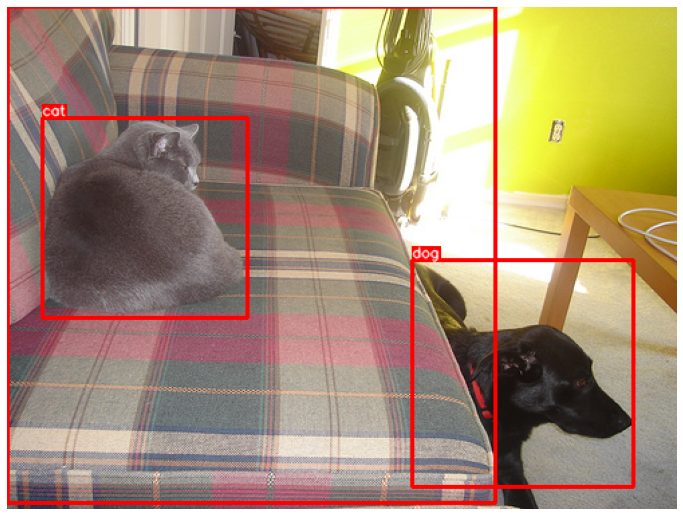

In [6]:
idx = 6
import PIL
img = PIL.Image.open(img_paths[idx]).convert('RGB') # cv2.imread(img_paths[idx])
img = np.array(img)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape
print(f'{height, width}')

bboxes = []
labels = []
for d in detections[idx]:
    x, y, w, h = d['bounding_box']
    bboxes.append([x * width, y * height, w * width, h * height])
    labels.append(d['label'])
print(bboxes)

visualize(img, bboxes, labels)

In [7]:
aug_transform = A.Compose([
    A.RandomResizedCrop(400, 400),
    A.HorizontalFlip(p=0.5),
], bbox_params=A.BboxParams(format='coco', 
                            min_visibility=0.5, label_fields=['labels']),)

num bboxes left: 0


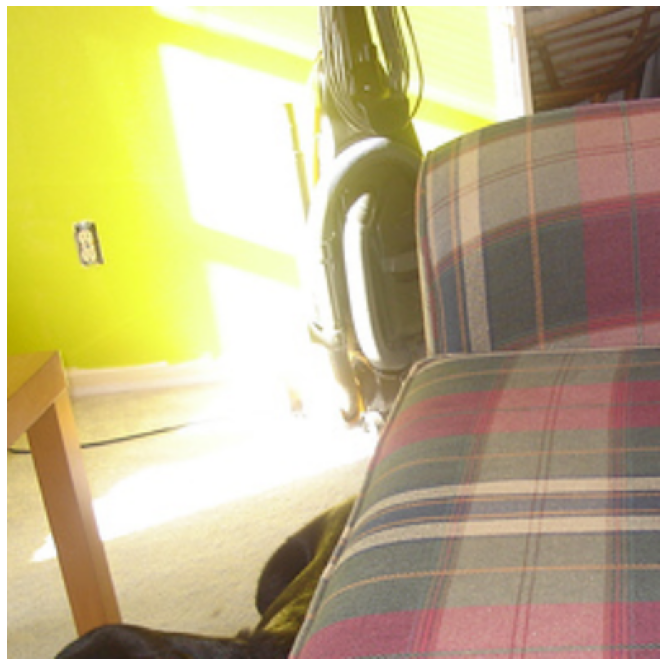

In [8]:
transformed = aug_transform(image=img,
                           bboxes=bboxes,
                           labels=labels)
print(f'num bboxes left: {len(transformed["bboxes"])}')
visualize(transformed['image'], transformed['bboxes'], transformed['labels'])

In [9]:
import torchvision.transforms as T
torch_transforms = [T.Resize(400), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

In [10]:
torch_transforms = T.Compose(torch_transforms)
torch_transforms(img)

TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>